# Classification on Wisconsin Breast Cancer Dataset with Artificial Neural Networks

1. Data Preprocessing and quick analysis
2. Building ANN
3. Making Predictions So let's get started!

## 1. PreProcessing Dataset

### Import Libraries  and Load the dataset

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# load dataset
dataset = pd.read_csv("breast-cancer-data.csv")

#dataset.head()

### Data Exploration and Data Quality

In [35]:
#Method For Data Exporation

def exploreData(dataframe):
    # Preview dataset
    print("Dataset Head")
    print(dataframe.head(3))
    print("--" * 50)
    
    # Features in dataset
    print("Dataset Atrributes")
    print(dataframe.columns.values)
    print("--" * 50)
    
     # view distribution of numerical features across the data set
    print("Dataset Numerical Features")
    print(dataframe.describe())
    print("--" * 50)
    
    # View How many samples and how many missing values for each feature
    print("Dataset Features Details")
    print(dataframe.info())
    print("--" * 50)
    
    # view distribution of categorical features across the data set
    print("Dataset Categorical Features")
    print(dataframe.describe(include=['O']))
    print("--" * 50)
        
    #Checking for missing values
    print("Check for Missing Values")
    print(dataframe.isnull().sum())
    print("--" * 50)

     #Get number of instances and number of attributes
    print("Number of Instances and Attributes")
    print(dataframe.shape)
    print("--" * 50)
    
exploreData(dataset)
# Distribution of Output Variable
dataset['diagnosis'].value_counts()

Dataset Head
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38           122.8     1001.0   
1    842517         M        20.57         17.77           132.9     1326.0   
2  84300903         M        19.69         21.25           130.0     1203.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   

      ...       texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0     ...               17.33            184.6      2019.0            0.1622   
1     ...               23.41            158.8      1956.0            0.1238   
2     ...               25.53            152.5      1709.0            0.1444   

   compactness_worst  concavity_worst  c

B    357
M    212
Name: diagnosis, dtype: int64

### Observations and Fixes
We have 569 instances of data with 33columns(attributes). 
- The last column **UnNamed** has all null values, so we remove it from the dataset.
- The **Id** column should also be excluded since it does not have any effect on the classification
- We have one column **diagnosis** which has categorical values. These values will be changed to dummy values(one code encoded)
- Our data does not contain any missing values. :) 

In [2]:
#Get all features excluding first column(0-Id) and last column(32-UnNamed)
X = dataset.iloc[:,2:32] 
# Get second column which contains the outcomes(Benign and Malignant)
y = dataset.iloc[:,1] 

NameError: name 'dataframe' is not defined

### Encode Output

In [37]:
# encode class values as integers
print("Before encoding: ")
print(y[100:110]) 

# encoder = LabelEncoder()
# encoder.fit(y)
# encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
#dummy_y = np_utils.to_categorical(encoded_Y)

labelencoder_X_1 = LabelEncoder()
y = labelencoder_X_1.fit_transform(y)

print("\nAfter encoding: ")
print(y[100:110])

Before encoding: 
100    M
101    B
102    B
103    B
104    B
105    M
106    B
107    B
108    M
109    B
Name: diagnosis, dtype: object

After encoding: 
[1 0 0 0 0 1 0 0 1 0]


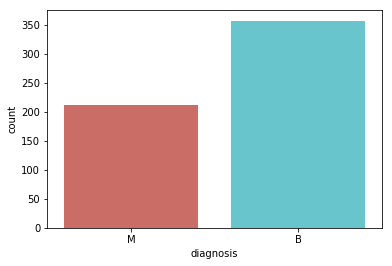

<Figure size 432x288 with 0 Axes>

In [38]:
#Checking if data is unbalanced. Output is 60:40 hence not bad
sns.countplot(x='diagnosis',data=dataset,palette='hls')
plt.show()
plt.savefig('count_plot')

In [1]:
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    
X = dataset.loc[:, dataset.columns != 'diagnosis']
y = dataset.loc[:, dataset.columns == 'diagnosis']

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

os_data_X,os_data_y=os.fit_sample(X, y)
os_data_X = pd.DataFrame(data=os_data_X,columns=dataset.columns[:8] )
os_data_y = pd.DataFrame(data=os_data_y.ravel(),columns=['diagnosis'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y.values.ravel()[os_data_y['diagnosis'].values.ravel()==0]))
print("Number of subscription",len(os_data_y.values.ravel()[os_data_y['diagnosis'].values.ravel()==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y.values.ravel()[os_data_y['diagnosis'].values.ravel()==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y.values.ravel()[os_data_y['diagnosis'].values.ravel()==1])/len(os_data_X))

NameError: name 'warnings' is not defined

### Feature Scaling (To be edited)
Now let's apply features scaling. Scaling ensures that just because some features are big, the model won't lead to using them as a main predictor

In [16]:
#Feature Scaling
sc = StandardScaler()
X = sc.fit_transform(X)

## 2. Build ANN

### Define the neural network model

input_dim - number of columns of the dataset

output_dim - number of outputs to be fed to the next layer, if any

activation - activation function which is ReLU in this case

init - the way in which weights should be provided to an ANN

In [20]:
# define baseline model
def baseline_model():
    # Initialising the ANN
    model = Sequential()
    # Adding the input layer and first hidden layer
    model.add(Dense(16, kernel_initializer="uniform", activation = 'relu', input_dim = 30))
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate = 0.1))
    
    # Adding the second hidden layer
    model.add(Dense(16, kernel_initializer="uniform", activation = 'relu'))
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate = 0.1))
    
    # Adding the output layer
    #classifier.add(Dense(2, init='uniform', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer="uniform", activation = 'sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Creating our KerasClassifier for use in scikit-learn
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

### Performing k-fold cross validation

In [21]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

### Evaluating the model with k-fold cross validation

In [22]:
#Evaluating out estimator on our dataset using 10-fold cross valiation
results = cross_val_score(estimator, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 97.18% (2.12%)


### Getting the confusion matrix

In [24]:
#Get our result predictions 
y_pred = cross_val_predict(estimator, X, y, cv=kfold)
#Get our confusion matrix
conf_mat = confusion_matrix(y, y_pred)
class_report = classification_report(y,y_pred)
print(conf_mat)
print(class_report)

[[350   7]
 [  8 204]]
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       357
          1       0.97      0.96      0.96       212

avg / total       0.97      0.97      0.97       569



### Transforming to a plot

In [30]:
#Getting Accuracy, Specificity and Sensitivity from the confusion matrix
total1=sum(sum(conf_mat))
#Accuracy
accuracy=((conf_mat[0,0]+conf_mat[1,1])/total1)*100

#accuracy = np.diag(conf_mat) / np.sum(conf_mat, axis = 0)
#Sensitivity
sensitivity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])*100
#sensitivity = np.diag(conf_mat) / np.sum(conf_mat, axis = 1)
#Specificity
specificity = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])*100

print(accuracy)
print(sensitivity)
print(specificity)
#print("[{} {} {}]".format(round(specificity1, 2), round(specificity2, 2),round(specificity3, 2)))

97.36379613356766
98.0392156862745
96.22641509433963


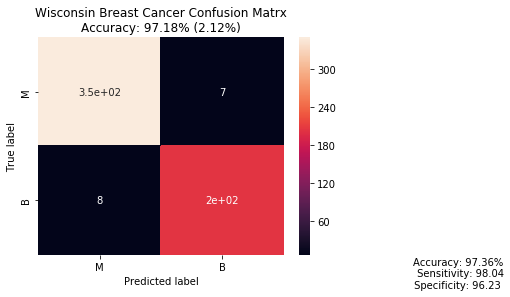

In [31]:
# Transform to df for easier plotting
cm_df = pd.DataFrame(conf_mat,
                     index = ['M','B'], 
                     columns = ['M','B'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Wisconsin Breast Cancer Confusion Matrx\nAccuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figtext(1.30, 0.01, 'Accuracy: {}%\n Sensitivity: {}\n Specificity: {} '.format(round(accuracy, 2),round(sensitivity, 2),round(specificity, 2)), horizontalalignment='right')
plt.show()